In [8]:
import numpy as np
import cv2
import matplotlib.patches as patches   #用于生成锚框形状
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [9]:
#scale、ratio用于设置9种不同尺寸的锚框
scale = [1,2,4]
ratio = [0.5,1,2]
feature_mapX = 8   #假设输出的特征图长度
feature_mapY = 8   #假设输出的特征图宽度
stride = 8   #特征图的缩放倍数

In [10]:
scale,ratio = np.meshgrid(scale,ratio)   #生成网格点坐标矩阵
print(scale.flatten())   
print(ratio.flatten())
#计算得到不同的变化尺度
scale_X = scale * np.sqrt(ratio)
scale_Y = scale / np.sqrt(ratio)
print("scale_X:\n",scale_X)
print("scale_Y:\n",scale_Y)

[1 2 4 1 2 4 1 2 4]
[0.5 0.5 0.5 1.  1.  1.  2.  2.  2. ]
scale_X:
 [[0.70710678 1.41421356 2.82842712]
 [1.         2.         4.        ]
 [1.41421356 2.82842712 5.65685425]]
scale_Y:
 [[1.41421356 2.82842712 5.65685425]
 [1.         2.         4.        ]
 [0.70710678 1.41421356 2.82842712]]


In [11]:
source_X = np.arange(0,feature_mapX) * stride   #乘以缩放倍数得到上采样的原图长度
source_Y = np.arange(0,feature_mapY) * stride   #乘以缩放倍数得到上采样的原图宽度
source_X,source_Y = np.meshgrid(source_X,source_Y)
center_X,anchor_X = np.meshgrid(source_X,scale_X)   #得到9个锚框的中心和对应的锚框长度
center_Y,anchor_Y = np.meshgrid(source_Y,scale_Y)   #得到9个锚框的中心和对应的锚框宽度
print(center_X.shape)
print(center_Y.shape)

(9, 64)
(9, 64)


In [15]:
anchor_center = np.stack([center_Y,center_X],axis=2).reshape(-1,2)   #锚框中心位置
anchor_size = np.stack([anchor_Y,anchor_X],axis=2).reshape(-1,2)   #锚框尺寸
boxes=np.concatenate([anchor_center - 0.5*anchor_size, anchor_center + 0.5*anchor_size],axis=1)
print(boxes.shape)

(576, 4)


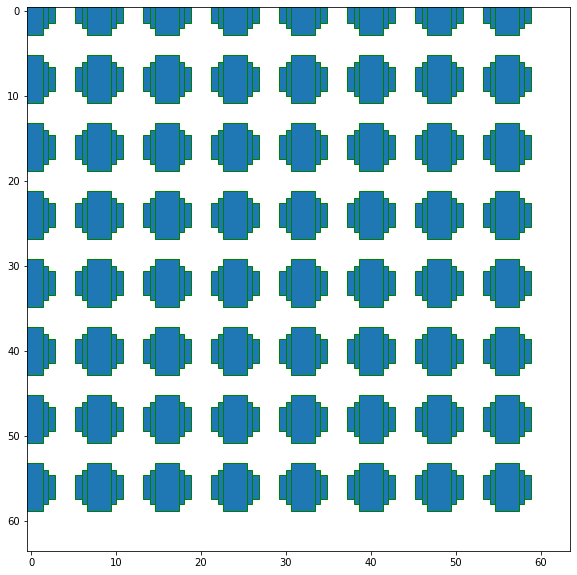

In [16]:
plt.figure(figsize=(10,10))
img = np.ones((64,64,3))
plt.imshow(img)
axs = plt.gca()
for i in range(boxes.shape[0]):
    box = boxes[i]   #读取锚框信息
    rec = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],edgecolor='g')  #画出锚框
    axs.add_patch(rec)

In [18]:
#RPN网络构建
k = 9   #锚框数量
feature_map = keras.layers.Input(shape=(None,None,100))
conv_3x3 = keras.layers.Conv2D(filters=512,kernel_size=(3,3))(feature_map)   #3x3卷积
#锚框坐标
output_deltas = keras.layers.Conv2D(filters=4*k,kernel_size=(1,1),activation='linear')(conv_3x3)   
#分类得分
output_scores =keras.layers.Conv2D(filters=1*k,kernel_size=(1,1),activation='sigmoid')(conv_3x3)   
model = keras.Model(inputs=[feature_map], outputs=[output_scores, output_deltas])

In [19]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, None, None, 5 461312      input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, None, None, 9 4617        conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, None, None, 3 18468       conv2d_3[0][0]                   
Total params: 484,397
Trainable params: 484,397
Non-trainable params: 0
____________________

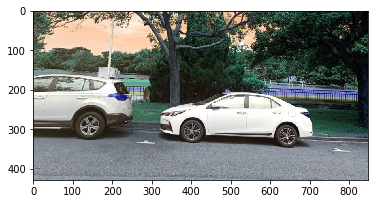

In [20]:
car_img = cv2.imread("car.jpg")
plt.imshow(car_img)
plt.show()	

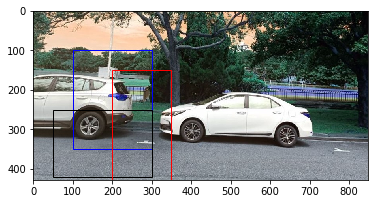

In [22]:
three_boxes = [[300,350,100,100],[300,420,50,250],[350,450,200,150]]   #构建虚拟检测框
plt.imshow(car_img)
ax = plt.gca()
colors = ['blue','black','red']   #设定三个检测框的颜色
for i in range(len(colors)):
    box = three_boxes[i]   #读取检测框的信息
    draw_box = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],facecolor='none', edgecolor=colors[i])   #绘制检测框
    ax.add_patch(draw_box)

tf.Tensor([0], shape=(1,), dtype=int32)


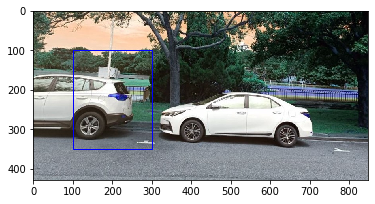

In [23]:
nor_boxes = np.array(three_boxes)/1000
scores = [0.8,0.7,0.6]   #检测框的得分分别是0.8、0.7和0.6
count = 3
threshold = 0.1   #重叠度阈值
result = tf.image.non_max_suppression(nor_boxes,scores,count,threshold)   #非极大值抑制
print(result)
plt.imshow(car_img)
ax = plt.gca()
sel_box = three_boxes[result[0].numpy()] 
draw_box = patches.Rectangle((sel_box[0],sel_box[1]),sel_box[2]-sel_box[0],sel_box[3]-sel_box[1],facecolor='none',edgecolor=colors[int(result.numpy())])   #画出未被去除的检测框
ax.add_patch(draw_box)